# Training CIFAIR10- Starter Code

In [3]:
import os
import datetime
from scipy import misc
import imageio
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib as mp
from math import sqrt

#compatibility for tf v2.0
if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior() 
# setup

(?, 28, 28, 32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
grid: 32 = (4, 8)
step 0, training accuracy 0.10000000149011612, test accuracy 0.10000000149011612, train loss 2.3393940925598145, test loss 2.339158773422241
step 100, training accuracy 0.2628999948501587, test accuracy 0.26100000739097595, train loss 2.1144297122955322, test loss 2.108132839202881
step 200, training accuracy 0.2872999906539917, test accuracy 0.28700000047683716, train loss 2.0200319290161133, test loss 2.0176632404327393
step 300, training accuracy 0.30329999327659607, test accuracy 0.30399999022483826, train loss 1.9610953330993652, test loss 1.9632021188735962
step 400, training accuracy 0.3416999876499176, test accuracy 0.3330000042915344, train loss 1.8776334524154663, test loss 1.8852441310882568
step 500, training accuracy 0.3702999949455261, test accuracy 0.3790000081062317, train loss 1.8094701766967773, test loss 1.81847321987152

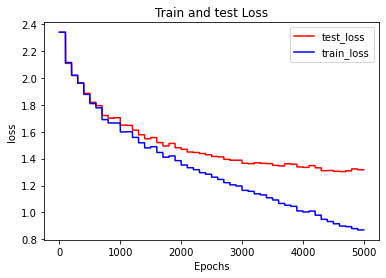

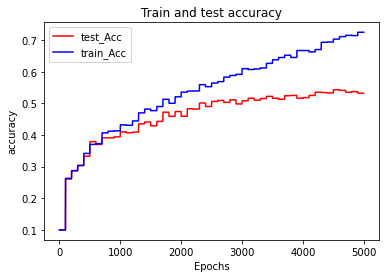

test accuracy 0.532


In [5]:


def weight_variable(shape):
    '''
    Initialize weights
    :param shape: shape of weights, e.g. [w, h ,Cin, Cout] where
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters
    Cout: the number of filters
    :return: a tensor variable for weights with initial values
    '''
    initial = tf.initializers.glorot_uniform()
    W = tf.Variable(initial(shape = shape))
    return W

def bias_variable(shape):
    '''
    Initialize biases
    :param shape: shape of biases, e.g. [Cout] where
    Cout: the number of filters
    :return: a tensor variable for biases with initial values
    '''
    initial = tf.constant(0.1, shape = shape)
    b = tf.Variable(initial)
    return b

def conv2d(x, W):
    '''
    Perform 2-D convolution
    :param x: input tensor of size [N, W, H, Cin] where
    N: the number of images
    W: width of images
    H: height of images
    Cin: the number of channels of images
    :param W: weight tensor [w, h, Cin, Cout]
    w: width of the filters
    h: height of the filters
    Cin: the number of the channels of the filters = the number of channels of images
    Cout: the number of filters
    :return: a tensor of features extracted by the filters, a.k.a. the results after convolution
    '''
    h_conv = tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')
    return h_conv

def max_pool_2x2(x):
    '''
    Perform non-overlapping 2-D maxpooling on 2x2 regions in the input data
    :param x: input data
    :return: the results of maxpooling (max-marginalized + downsampling)
    '''
    h_max = tf.nn.max_pool(x, ksize = [1, 2, 2, 1],
                              strides = [1, 2, 2, 1],
                              padding = 'SAME')
    return h_max
def put_kernels_on_grid (kernel, pad = 1):

  '''Visualize conv. filters as an image (mostly for the 1st layer).
  Arranges filters into a grid, with some paddings between adjacent filters.
  Args:
    kernel:            tensor of shape [Y, X, NumChannels, NumKernels]
    pad:               number of black pixels around each filter (between them)
  Return:
    Tensor of shape [1, (Y+2*pad)*grid_Y, (X+2*pad)*grid_X, NumChannels].
  '''
  # get shape of the grid. NumKernels == grid_Y * grid_X
  def factorization(n):
    for i in range(int(sqrt(float(n))), 0, -1):
      if n % i == 0:
        if i == 1: print('Who would enter a prime number of filters')
        return (i, int(n / i))
  (grid_Y, grid_X) = factorization (kernel.get_shape()[3].value)
  print ('grid: %d = (%d, %d)' % (kernel.get_shape()[3].value, grid_Y, grid_X))

  x_min = tf.reduce_min(kernel)
  x_max = tf.reduce_max(kernel)
  kernel = (kernel - x_min) / (x_max - x_min)

  # pad X and Y
  x = tf.pad(kernel, tf.constant( [[pad,pad],[pad, pad],[0,0],[0,0]] ), mode = 'CONSTANT')

  # X and Y dimensions, w.r.t. padding
  Y = kernel.get_shape()[0] + 2 * pad
  X = kernel.get_shape()[1] + 2 * pad

  channels = kernel.get_shape()[2]

  # put NumKernels to the 1st dimension
  x = tf.transpose(x, (3, 0, 1, 2))
  # organize grid on Y axis
  x = tf.reshape(x, tf.stack([grid_X, Y * grid_Y, X, channels]))

  # switch X and Y axes
  x = tf.transpose(x, (0, 2, 1, 3))
  # organize grid on X axis
  x = tf.reshape(x, tf.stack([1, X * grid_X, Y * grid_Y, channels]))

  # back to normal order (not combining with the next step for clarity)
  x = tf.transpose(x, (2, 1, 3, 0))

  # to tf.image_summary order [batch_size, height, width, channels],
  #   where in this case batch_size == 1
  x = tf.transpose(x, (3, 0, 1, 2))

  # scaling to [0, 255] is not necessary for tensorboard
  return x

ntrain = 1000 # per class
ntest =  100 # per class
nclass =  10 # number of classes
imsize = 28
nchannels = 1
batchsize = 64

Train = np.zeros((ntrain*nclass,imsize,imsize,nchannels))
Test = np.zeros((ntest*nclass,imsize,imsize,nchannels))
LTrain = np.zeros((ntrain*nclass,nclass))
LTest = np.zeros((ntest*nclass,nclass))

itrain = -1
itest = -1
for iclass in range(0, nclass):
    for isample in range(0, ntrain):
        path = './CIFAR10/CIFAR10/Train/%d/Image%05d.png' % (iclass,isample)
        #http://localhost:8889/tree/OneDrive/Documents/Univdrsity/Rice_University/Assignment02/CIFAR10/CIFAR10/Test
        im = imageio.imread(path); # 28 by 28
        im = im.astype(float)/255
        itrain += 1
        Train[itrain,:,:,0] = im
        LTrain[itrain,iclass] = 1 # 1-hot lable
    for isample in range(0, ntest):
        path = './CIFAR10/CIFAR10/Test/%d/Image%05d.png' % (iclass,isample)
        im = imageio.imread(path); # 28 by 28
        im = im.astype(float)/255
        itest += 1
        Test[itest,:,:,0] = im
        LTest[itest,iclass] = 1 # 1-hot lable

sess = tf.InteractiveSession()
 
tf_data = tf.placeholder(tf.float32, [None, 28, 28, 1], name = 'tf_data') 
tf_labels = tf.placeholder(tf.float32, [None, 10], name = 'tf_lables')

# model
def main():
  #training parameters
  result_dir = './results/' # directory where the results from the training are
  test_result_dir = './testResults' # directory where the results from the test are
  
  #first convolutional layer
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])
  h_conv1 = tf.nn.relu(conv2d(tf_data, W_conv1) + b_conv1)
  print(h_conv1.shape)
  h_pool1 = max_pool_2x2(h_conv1)

  #second convolutional layer
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])
  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pool_2x2(h_conv2)

  #fully connected layer 1
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])
  h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  #dropout
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  #fully connected layer 2 (output layer)
  w_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])
  y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, w_fc2) + b_fc2, name = 'y') 

  
  # loss
  cross_entrophy = tf.reduce_mean(-tf.reduce_sum(tf_labels * tf.log(y_conv),
                                                 reduction_indices = [1]))
  #optimization 
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entrophy)
  # evaluation
  correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(tf_labels, 1))
  # accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), 
                            name = 'accuracy')
  
  # Add a scalar summary for the snapshot loss for training.
  tf.summary.scalar(cross_entrophy.op.name, cross_entrophy)
  #Add a scalar summary for the snapshot accuracy for training:
  tf.summary.scalar(accuracy.op.name, accuracy)

  # Visualize conv1 kernels
  with tf.variable_scope('conv1'):
    grid = put_kernels_on_grid (W_conv1)
    tf.summary.image('weights', grid, max_outputs=1)
  # Visualize the activations
  with tf.name_scope('Layer1/Conv1/Activations'):
    h_conv1_reshaped = tf.keras.backend.reshape(h_conv1, (-1, 28, 28, 1))
    tf.summary.image('Grayscale', h_conv1_reshaped, max_outputs = 1)
  with tf.name_scope('Layer2/Conv2/Activations'):
    h_conv2_reshaped = tf.keras.backend.reshape(h_conv2, (-1, 28, 28, 1))
    tf.summary.image('Grayscale', h_conv2_reshaped, max_outputs = 1)

  #statistics of activation function on convolutional layes on test images
  with tf.name_scope('Layer1/Conv1'):
      with tf.name_scope('Activation_after_relu'):
        max = tf.reduce_max(h_conv1)
        min = tf.reduce_min(h_conv1)
        mean = tf.reduce_mean(h_conv1)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(h_conv1 - mean)))
        tf.summary.scalar('h_conv1_min', min)
        tf.summary.scalar('h_conv1_max', max)
        tf.summary.scalar('h_conv1_mean', mean)
        tf.summary.scalar('h_conv1_std', stddev)
        tf.summary.histogram('h_conv1_hist', h_conv1)

  with tf.name_scope('Layer2/Conv2'):
      with tf.name_scope('Activation_after_relu'):
        max = tf.reduce_max(h_conv2)
        min = tf.reduce_min(h_conv2)
        mean = tf.reduce_mean(h_conv2)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(h_conv2 - mean)))
        tf.summary.scalar('h_conv2_min', min)
        tf.summary.scalar('h_conv2_max', max)
        tf.summary.scalar('h_conv2_mean', mean)
        tf.summary.scalar('h_conv2_std', stddev)
        tf.summary.histogram('h_conv2_hist', h_conv2)
  

  # Op to initialize the variables.
  sess.run(tf.global_variables_initializer())
  batch_xs = np.zeros((batchsize, 28, 28, 1))
  batch_ys = np.zeros((batchsize, nclass))
  nsamples = len(Train)
  
  # summary operation based on the TF collection of Summaries.
  summary_op = tf.summary.merge_all()
  # saver for writing training checkpoints.
  saver = tf.train.Saver()
  # Instantiate a SummaryWriter to output summaries and the Graph.
  summary_writer = tf.summary.FileWriter(result_dir, sess.graph)
  test_summary_writer = tf.summary.FileWriter(test_result_dir, sess.graph)
 
  TrainLoss = []
  TestLoss = []
  TrainAccuracy = []
  TestAccuracy = []
  steps = []
  max_step = 5000
  for i in range(max_step):
      perm = np.arange(nsamples)
      np.random.shuffle(perm)
      for j in range(batchsize):
          batch_xs[j,:,:,:] = Train[perm[j],:,:,:]
          batch_ys[j,:] = LTrain[perm[j],:]
      if i%100 == 0:
          train_accuracy = accuracy.eval(feed_dict = {tf_data:Train, tf_labels:LTrain, keep_prob: 1.0})
          train_loss = cross_entrophy.eval(feed_dict= {tf_data:Train, tf_labels:LTrain, keep_prob: 1.0})
          test_accuracy = accuracy.eval(feed_dict={tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
          test_loss = cross_entrophy.eval(feed_dict= {tf_data: Test, tf_labels: LTest, keep_prob: 1.0})
          print('step {}, training accuracy {}, test accuracy {}, train loss {}, test loss {}'.format(i,train_accuracy, test_accuracy,
                                                                                                      train_loss,test_loss))
          summary_str = sess.run(summary_op, feed_dict= {tf_data:batch_xs, 
                                                         tf_labels:batch_ys, keep_prob: 0.5}) 
          test_summary_str = sess.run(summary_op, feed_dict= {tf_data: Test, tf_labels: LTest, 
                                                              keep_prob: 0.5})  
          test_summary_writer.add_summary(test_summary_str, i)         
          summary_writer.add_summary(summary_str, i)
          summary_writer.flush() 
          test_summary_writer.flush()
      
      # saveing the checkpoints every 100 iterations
      if i % 1100 == 0 or i == max_step:
          checkpoint_file = os.path.join(result_dir, 'checkpoint')
          saver.save(sess, checkpoint_file, global_step=i)
          
      TrainAccuracy.append(train_accuracy)
      TestAccuracy.append(test_accuracy)
      TrainLoss.append(train_loss)
      TestLoss.append(test_loss)
      steps.append(i)

      optimizer.run(feed_dict={tf_data: batch_xs, tf_labels: batch_ys, keep_prob: 0.5}) # dropout only during training
           
  #plot the train, validation and test loss function
  plt.figure()
  plt.plot(steps, TestLoss, 'r-', label = 'test_loss')
  plt.plot(steps, TrainLoss, 'b-', label = 'train_loss')
  plt.title('Train and test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  #plot the train, validation and test accuracy
  plt.figure()
  plt.plot(steps, TestAccuracy, 'r-', label = 'test_Acc')
  plt.plot(steps, TrainAccuracy, 'b-', label = 'train_Acc')
  plt.title('Train and test accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  
  # test
  print("test accuracy %g"%test_accuracy)
  sess.close()

if __name__ == "__main__":
  main()